# RNNを使った文書分類
* RNNの出力を文書の潜在表現として利用し、文書分類を行う。
* 単語の埋め込みも含めて学習する。

## 準備
* ランタイムのタイプをGPUにしておこう。


* 再現性の確保については下記を参照。
 * https://pytorch.org/docs/stable/notes/randomness.html

In [1]:
import time
from collections import OrderedDict
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from matplotlib import pyplot as plt
#from torchtext.vocab import vocab # ここに書いておくとエラーが出る？？？

np.random.seed(123)
torch.manual_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

## IMDbデータの準備
* IMDbデータセットは`torchtext.datasets`から使うこともできる。
 * https://pytorch.org/text/stable/datasets.html
 * https://torchtext.readthedocs.io/en/latest/datasets.html
* だが、語彙集合を作成するために使う`torchtext.vocab.build_vocab_from_iterator`という関数がとても遅い・・・。
 * https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
* なので、ここではCountVectorizerで語彙集合を作ることにした。

In [3]:
!pip install ml_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from ml_datasets import imdb

train_data, test_data = imdb()
train_texts, train_labels = zip(*train_data)
test_texts, test_labels = zip(*test_data)

# ラベルは整数の1と0に変換しておく
label_id = { "pos":1, "neg":0 }

train_labels = [label_id[label] for label in train_labels]
test_labels = [label_id[label] for label in test_labels]

84131840it [00:02, 35602673.82it/s]                              


Untaring file...


In [5]:
train_texts[0]

"I may be biased, I am the author of the novel The Hungry Bachelors Club, self-published in 1994. The screenplay was written by my good friend and hungry bachelor, Fred Dresch, who was the inspiration for the character Marlon in the film. I couldn't be more pleased with the trailer, I hope to see the film in its entirety and I will further comment. But Jorja Fox, who plays Delmar Youngblood, my character, is stellar. She carries the bulk of the emotional vehicles in fine form. I couldn't have done better myself! This looks like real people, hardly formula driven and thankfully drives my statement against racial prejudice home, gracefully and heartfelt."

In [6]:
train_labels[0]

1

## sklearnのCountVectorizerによるトークン化
* 一般に、語彙集合を確定させるときは、訓練データだけを使う。

### CountVectorizerで語彙集合を作成
* ここで作った語彙集合のサイズを、あとで絞る。
* `CountVectorizer`の`token_pattern`を指定し、1文字の単語が消えないようにする。
 * ここでは、テキストを、bag-of-wordsとしてではなく、単語の列としてモデル化する。
 * その場合、例えば冠詞"a"が消えてしまうのは避けたい。
* ただし、下の正規表現だと、punctuationは消えてしまう。

In [7]:
# デフォルトの正規表現とは異なる正規表現を使う
vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")

# 訓練データのテキストをトークン化する
X = vectorizer.fit_transform(train_texts)

# 語彙集合を取得する
vocabulary = vectorizer.get_feature_names_out()
print(len(vocabulary))

74891


### 単語のdocument frequencyを計算
* このままだと語彙サイズが大きすぎる。
* 後で、語彙を絞り込むために、document frequencyを使うことにする。
 * document frequencyが小さい単語は、未知語として扱うことにする。

In [8]:
doc_freq = np.array((X > 0).sum(0)).squeeze()

* document frequencyでトップ10の単語を見てみる。

In [9]:
print(vocabulary[np.argsort(- doc_freq)][:10])

['the' 'a' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that']


## `torchtext`の語彙集合の作成
* 作り方は下記のリンク先を参照。
 * https://pytorch.org/text/stable/vocab.html#id1

### OrderedDictを作成
 * torchtextで語彙集合を作成するとき、OrderedDictを渡すことになっているため。

In [10]:
vocab_ordered_dict = OrderedDict(zip(vocabulary, doc_freq))
len(vocab_ordered_dict)

74891

* 適当な単語のdocument frequencyを見てみる。

In [11]:
vocab_ordered_dict["apple"]

48

### `torchtext`の語彙集合を作成
* ここでは、document frequencyが10未満の単語を未知語とすることで、語彙サイズを抑えている。
 * ここはチューニングする余地がある。

In [12]:
from torchtext.vocab import vocab

# 未知語は全て"<unk>"という特殊なトークンへ置き換えることにする
unknown_token = "<unk>"

# padding用のトークンを作っておく
padding_token = "<pad>"

# OrderedDictをもとにtorchtextでの語彙集合を作成
#   min_freqを指定すると、低頻度語は全て未知語として扱われる。
#   ここで、OrderedDictの各keyに対応するvalueが用いられる。
#   （つまり、document frequency以外の値で未知語を決めても構わない。）
vocab = vocab(
    vocab_ordered_dict, min_freq=10,
    specials=[unknown_token, padding_token],
    )

# 語彙にない単語のインデックスは全て"<unk>"と同じインデックスになるよう、設定する
vocab.set_default_index(vocab[unknown_token])

print(len(vocab))

18563


## テキストを単語idの列へ変換する関数

In [13]:
# fit済みのCountVectorizerから、前処理とトークナイザを持ってくる
preprocessor = vectorizer.build_preprocessor()
tokenizer = vectorizer.build_tokenizer()

# 前処理、トークナイザ、インデックス列への変換を、一つの処理としてまとめる
text_pipeline = lambda x: vocab(tokenizer(preprocessor(x)))

* このトークナイザでトークン化すると、punctuationは消えることに注意。

In [14]:
text = "This is a fnekjfjd."
print(preprocessor(text))
print(tokenizer(preprocessor(text)))
print(text_pipeline(text))

this is a fnekjfjd.
['this', 'is', 'a', 'fnekjfjd']
[16665, 8906, 272, 0]


* 特殊なトークンには、以下のインデックスが割り振られている。

In [15]:
vocab.get_stoi()['<pad>']

1

In [16]:
vocab.get_stoi()['<unk>']

0

* インデックスから単語への変換は、以下のように行うことができる。

In [17]:
vocab.get_itos()[1001]

'apple'

## Dataset

### 全テキストのトークン化
* 単語インデックスの列への変換から、テンソルへの変換まで、おこなっている。

In [18]:
train_tokens = [torch.tensor(text_pipeline(text), dtype=torch.int64) for text in train_texts]
test_tokens = [torch.tensor(text_pipeline(text), dtype=torch.int64) for text in test_texts]

In [19]:
print(train_tokens[0])

tensor([ 8237, 10332,  1605,  1805,  8237,   759, 16598,  1329, 11473, 16598,
        11349, 16598,  8194,     0,  3220, 14568, 12986,  8430,   128, 16598,
        14457, 17998, 18422,  2446, 10994,  7232,  6812,   843,  8194,  1414,
         6776,     0, 18178, 17998, 16598,  8679,  6637, 16598,  2852, 10224,
         8430, 16598,  6404,  8237,  3852, 16322,  1605, 10826, 12378, 18292,
        16598, 16959,  8237,  8070, 16806, 14538, 16598,  6404,  8430,  8938,
         5728,   843,  8237, 18221,  6892,  3381,  2429,     0,  6727, 18178,
        12367,     0,     0, 10994,  2852,  8906, 15755, 14763,  2649, 16598,
         2357, 11473, 16598,  5574, 17678,  8430,  6432,  6681,  8237,  3852,
        16322,  7711,  5062,  1789, 11001, 16665,  9869,  9706, 13307, 12085,
         7641,  6691,  5207,   843, 16590,  5210, 10994, 15716,   590, 13142,
        12661,  8019,  7284,   843,  7774])


### 自前のデータセットの定義

In [20]:
class MyTextDataset(Dataset):
  def __init__(self, labels, tokens):
    self.labels = labels
    self.tokens = tokens

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    return self.labels[index], self.tokens[index]

train_dataset = MyTextDataset(train_labels, train_tokens)
test_dataset = MyTextDataset(test_labels, test_tokens)

### validation setの切り分け

In [21]:
valid_size = len(train_dataset) // 5
train_size = len(train_dataset) - valid_size
test_size = len(test_dataset)

split_train_, split_valid_ = random_split(train_dataset, [train_size, valid_size])

## DataLoader

### RNNの入力として使えるミニバッチを作る関数を定義
* paddingして、同じミニバッチに含まれる単語id列の長さを揃える関数。
* この関数は、DataLoaderクラスのインスタンスを作るときに、`collate_fn`の値として指定する。

In [22]:
# paddingに使うトークンのインデックスを取得
PAD_IDX = vocab.get_stoi()[padding_token]

def collate_batch(batch):
  labels, tokens = zip(*batch)
  labels = torch.tensor(labels, dtype=torch.int64)
  tokens = pad_sequence(tokens, padding_value=PAD_IDX)
  return labels, tokens

* 試しにバッチサイズ4でDataLoaderを作って、ミニバッチの中身を見てみる。

In [23]:
BATCH_SIZE = 4
train_loader = DataLoader(split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [24]:
labels, tokens = next(iter(train_loader))
print(labels)
print(tokens.shape)
print(tokens)

tensor([0, 1, 0, 0])
torch.Size([442, 4])
tensor([[ 1235, 16598, 16665, 18130],
        [16598, 11349, 10904,  8906],
        [11035,  8906, 13324, 16665],
        ...,
        [    1,     1,  3936,     1],
        [    1,     1,  1249,     1],
        [    1,     1,  6404,     1]])


* ミニバッチのサイズは64にしておく。
 * ここはチューニングできる。

In [25]:
BATCH_SIZE = 64
train_loader = DataLoader(split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

## モデル
* LSTMを使う（GRUに変えても良い）
 * http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [26]:
VOCAB_SIZE = len(vocab)
NUM_CLASS = 2
EMSIZE = 64
HID_DIM = 64

In [27]:
class RNNTextSentiment(nn.Module):
  def __init__(self, emb_dim, hid_dim,
               num_class, vocab_size, padding_idx, p=0.0, num_layers=1):
    super().__init__()

    self.input_dim = vocab_size
    self.emb_dim = emb_dim
    self.hid_dim = hid_dim
    self.dropout = p
    self.num_layers = num_layers

    self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
    self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=num_layers)
    self.fc = nn.Linear(hid_dim * 2, num_class)
    self.dropout = nn.Dropout(p=p)

  def forward(self, src):
    # embeddedの形は(トークン列長, バッチサイズ, 埋め込み次元数)
    embedded = self.dropout(self.embedding(src))

    # outputsの形は(トークン列長, バッチサイズ, 隠れ状態の次元数)
    # hiddenの形は(1, バッチサイズ, 隠れ状態の次元数)
    outputs, (hidden, _) = self.rnn(embedded)

    # mean_outputsの形は(バッチサイズ, 隠れ状態の次元数)
    # hiddenの形は(バッチサイズ, 隠れ状態の次元数)
    mean_outputs = outputs.mean(0)
    #hidden = hidden.squeeze()
    hidden = hidden.mean(0)

    return self.fc(torch.cat((mean_outputs, hidden), dim=1))

In [28]:
def newModel(numLayers):
  model = RNNTextSentiment(
      EMSIZE, HID_DIM, NUM_CLASS, VOCAB_SIZE,
      padding_idx=PAD_IDX,
      p=0.5,
      num_layers=numLayers
      ).to(device)

  print(model)
  return model

## 最適化アルゴリズム

In [29]:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

* パラメータの数を数えてみる。

In [30]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

#print(f'The model has {count_parameters(model):,} trainable parameters.')

* token embeddingに使うパラメータの個数だけを数えてみる。

In [31]:
def count_embedding_parameters(model):
  return sum(p.numel() for p in model.embedding.parameters() if p.requires_grad)

#print(f'The model has {count_embedding_parameters(model):,} trainable embedding parameters.')

## 損失関数

In [32]:
criterion = nn.CrossEntropyLoss()

## 訓練を行なう関数

In [33]:
def train(model, dataloader, clip=1.):
  model.train()
  total_loss, total_acc, total_count = 0, 0, 0
  for label, text in dataloader:
    label, text = label.to(device), text.to(device)
    output = model(text)
    loss = criterion(output, label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    optimizer.zero_grad()
    n_instances = label.size(0)
    total_loss += loss.item() * n_instances
    total_acc += (output.argmax(1) == label).sum().item()
    total_count += n_instances
  return total_loss / total_count, total_acc / total_count

## 評価を行なう関数

In [34]:
def evaluate(model, dataloader):
  model.eval()
  total_loss, total_acc, total_count = 0, 0, 0
  for label, text in dataloader:
    label, text = label.to(device), text.to(device)
    with torch.no_grad():
      output = model(text)
      loss = criterion(output, label)
      n_instances = label.size(0)
      total_loss += loss.item() * n_instances
      total_acc += (output.argmax(1) == label).sum().item()
      total_count += n_instances
  return total_loss / total_count, total_acc / total_count

## 時間表示用の関数

In [35]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time // 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

## 学習の実行

In [36]:
N_EPOCHS = 32
# レイヤ数のチューニング：[1, 2, 3, 4]
numLayerList = [1, 2, 3, 4]
history_acc_list, history_los_list={}, {}
test_acc_list, test_los_list =[], []

for numLayer in numLayerList:

    print(f"========レイヤ数：{numLayer}=========")
    # モデル初期化
    model = newModel(numLayer)

    # optimizer初期化
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    valid_los_list, valid_acc_list =[], []

    for epoch in range(1, N_EPOCHS + 1):

        start_time = time.time()
        train_loss, train_acc = train(model, train_loader)
        valid_loss, valid_acc = evaluate(model, valid_loader)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Valid Dataのlossとscoreを追加
        valid_los_list.append(valid_loss)
        valid_acc_list.append(valid_acc)

        print(f'Epoch {epoch} | time in {epoch_mins} minutes, {epoch_secs} seconds')
        print(f'\tLoss {train_loss:.4f} (train)\t|\tAcc {train_acc*100:.1f}% (train)')
        print(f'\tLoss {valid_loss:.4f} (valid)\t|\tAcc {valid_acc*100:.1f}% (valid)')
    
    # 各Layには、Valid Dataのlossとscoreを追加
    history_los_list[numLayer] = valid_los_list
    history_acc_list[numLayer] = valid_acc_list

    # 各Layには、Test Dataのlossとscoreを追加
    los, acc = evaluate(model, test_loader)
    test_acc_list.append(acc)
    test_los_list.append(los)

========レイヤ数：1=========
RNNTextSentiment(
  (embedding): Embedding(18563, 64, padding_idx=1)
  (rnn): LSTM(64, 64)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch 1 | time in 0 minutes, 3 seconds
	Loss 0.6798 (train)	|	Acc 55.9% (train)
	Loss 0.6296 (valid)	|	Acc 65.3% (valid)
Epoch 2 | time in 0 minutes, 2 seconds
	Loss 0.6136 (train)	|	Acc 67.6% (train)
	Loss 0.6523 (valid)	|	Acc 69.8% (valid)
Epoch 3 | time in 0 minutes, 2 seconds
	Loss 0.5537 (train)	|	Acc 73.5% (train)
	Loss 0.5568 (valid)	|	Acc 75.3% (valid)
Epoch 4 | time in 0 minutes, 2 seconds
	Loss 0.5060 (train)	|	Acc 77.1% (train)
	Loss 0.6086 (valid)	|	Acc 74.6% (valid)
Epoch 5 | time in 0 minutes, 2 seconds
	Loss 0.4468 (train)	|	Acc 80.4% (train)
	Loss 0.5124 (valid)	|	Acc 79.0% (valid)
Epoch 6 | time in 0 minutes, 2 seconds
	Loss 0.4090 (train)	|	Acc 82.5% (train)
	Loss 0.4954 (valid)	|	Acc 79.0% (valid)
Epoch 7 | time in 0 minutes, 3 seconds
	Loss 0.3820 (tr

# 課題6
* 上のコードを動かして、感情分析を実践してみよう。
* 余裕があれば、ハイパーパラメータをチューニングして、分類性能を上げてみよう。
 * 例えば、LSTMのレイヤ数を2以上にすると、性能は上がるだろうか？

### 感情分析を実践

In [37]:
# データを準備
self_texts = ["This film is very interesting. I like it", "Do not watch, It is worst"]
self_labels = [1, 0]  #　"pos":1, "neg":0

# トークン化
self_tokens = [torch.tensor(text_pipeline(text), dtype=torch.int64) for text in self_texts]

# DataSet生成
self_dataset = MyTextDataset(self_labels, self_tokens)

# Data Loader生成
self_loader = DataLoader(self_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [38]:
# 評価結果により、正解率は100％です。
self_loss, self_acc = evaluate(model, self_loader)
print(f'\tLoss {self_loss:.4f} (test)\t|\tAcc {self_acc*100:.1f}% (test)')

	Loss 0.0320 (test)	|	Acc 100.0% (test)


### LSTMのレイヤ数のチューニング

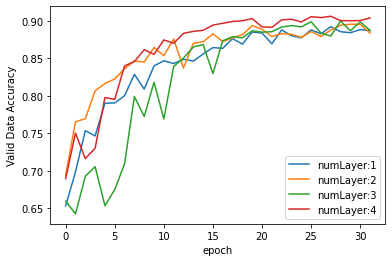

In [39]:
# LSTMのレイヤ数：[1, 2, 3, 4]
# Valid Dataのスコア結果

for i in numLayerList:
  plt.plot(history_acc_list[i], label=f"numLayer:{i}")
plt.xlabel('epoch')
plt.ylabel('Valid Data Accuracy')
plt.legend()

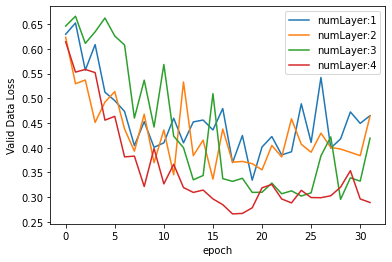

In [40]:
# LSTMのレイヤ数：[1, 2, 3, 4]
# Valid Dataのloss結果

for i in numLayerList:
  plt.plot(history_los_list[i], label=f"numLayer:{i}")
plt.xlabel('epoch')
plt.ylabel('Valid Data Loss')
plt.legend()

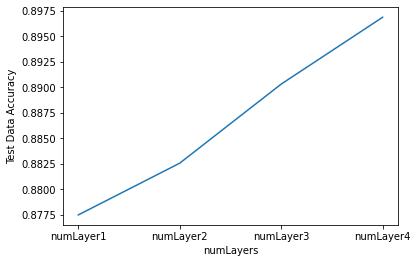

In [41]:
# LSTMのレイヤ数：[1, 2, 3, 4]
# Test Dataの正解率結果
# 考査：レイヤ数は４を設定する場合、スコアは高いです。レイア数は多くにつれて、スコアは高くなります。

plt.plot([1, 2, 3, 4], test_acc_list)
plt.xlabel("numLayers")
plt.ylabel("Test Data Accuracy")
plt.xticks([1, 2, 3, 4], ["numLayer1", "numLayer2", "numLayer3", "numLayer4"])
plt.show()

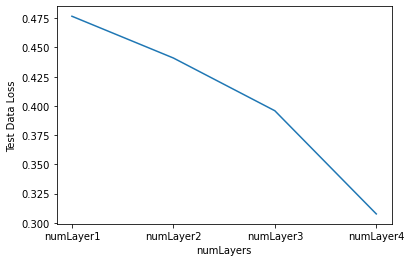

In [42]:
# LSTMのレイヤ数：[1, 2, 3, 4]
# Test Dataのloss結果
# 考査：レイヤ数は４の場合、lossは一番低いです

plt.plot([1, 2, 3, 4], test_los_list)
plt.xlabel("numLayers")
plt.ylabel("Test Data Loss")
plt.xticks([1, 2, 3, 4], ["numLayer1", "numLayer2", "numLayer3", "numLayer4"])
plt.show()